## Data Preprocessing & Modelling Pipeline

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import joblib
from utils.find_root import find_project_root

In [2]:
# Check GPU access for LSTM-AE training
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Built with CUDA:", tf.test.is_built_with_cuda())
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# test if GPU engages
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.matmul(a, a)
print(b)

TensorFlow version: 2.10.1
Built with CUDA: True
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tf.Tensor(
[[ 7. 10.]
 [15. 22.]], shape=(2, 2), dtype=float32)


In [3]:
# Retrieve the project root dynamically and set it as working directory
project_root = find_project_root()
os.chdir(project_root)

# Define output directories for ML models
MODEL_OUTPUT_DIR = "outputs/modelling/models/"
MODEL_INPIT_OUTPUT_DIR = "data/processed/model_input"

# Ensure output directories exist
os.makedirs(MODEL_OUTPUT_DIR, exist_ok=True)
os.makedirs(MODEL_INPIT_OUTPUT_DIR, exist_ok=True)

#### Step 0 - Dataset Loading and Splitting

In [4]:
# Step 0.1 Load dataset
DATASET_PATH = "data/processed/historical_merged/historical_IFS_merged_201702_to_202504.csv"
df = pd.read_csv(DATASET_PATH, parse_dates=['date'], index_col='date')
df = df.asfreq('h')
df

,temperature_2m,surface_pressure,precipitation,wind_speed_10m
date,,,,
2017-02-01 00:00:00,9.6,1008.2,0.0,14.6
2017-02-01 01:00:00,9.6,1007.4,0.0,14.6
2017-02-01 02:00:00,9.9,1006.8,0.6,15.1
2017-02-01 03:00:00,10.0,1006.5,0.3,15.0
2017-02-01 04:00:00,10.2,1006.2,0.3,15.5
...,...,...,...,...
2025-04-30 19:00:00,25.1,1016.6,0.0,10.1
2025-04-30 20:00:00,23.0,1016.8,0.0,11.9
2025-04-30 21:00:00,20.7,1017.3,0.0,11.9


In [5]:
# Step 0.2: Define chronological splits
train_start, train_end = "2017-02-01", "2025-01-31"
val_start, val_end = "2025-02-01", "2025-04-30"

# Step 0.3: Subset dataframe
df_train = df.loc[train_start:train_end]
df_val = df.loc[val_start:val_end]

print(f"Training set: {len(df_train)} rows (~{len(df_train)/24:.0f} days).")
print(f"Validation set: {len(df_val)} rows (~{len(df_val)/24:.0f}days).")

Training set: 70128 rows (~2922 days).
Validation set: 2136 rows (~89days).


#### Step 1 – Feature Transformation & Normalisation
**Goal**: Transform raw weather variables into scale-stable, model-ready features using rolling statistics. This includes z-scores, IQR scaling, smoothing, and log transforms. These steps are applied before training the Isolation Forest and LSTM-AE models to ensure consistency across training, validation, and inference.

In [6]:
# Step 1.1: Select features (precautionary)
features = ['temperature_2m', 'surface_pressure', 'wind_speed_10m', 'precipitation']
df_train = df_train[features].copy()
df_val =df_val[features].copy()

In [7]:
# Step 1.2: Set parameters for normalisation
window_60d = 1440 # rolling window size
min_periods_60d = 720 # minimum number of observations required for rolling calculations
window_12h = 12 # rolling window size for 12-hour rolling z-score
min_periods_12h = 6 # minimum number of observations required for rolling calculations for 12-hour rolling z-score
eps = 1e-6  # to avoid division by zero in rolling scaling calculations for precipitation and wind

In [8]:
# Step 1.3 Temperature and Surface Pressure: 60-day rolling z-scores
for col in ['temperature_2m', 'surface_pressure']:
    # Train set
    mean_train = df_train[col].rolling(window=window_60d, min_periods=min_periods_60d).mean()
    std_train = df_train[col].rolling(window=window_60d, min_periods=min_periods_60d).std()
    df_train[f'{col}_z'] = (df_train[col] - mean_train) / (std_train + eps)

    # Validation set
    mean_val = df_val[col].rolling(window=window_60d, min_periods=min_periods_60d).mean()
    std_val = df_val[col].rolling(window=window_60d, min_periods=min_periods_60d).std()
    df_val[f'{col}_z'] = (df_val[col] - mean_val) / (std_val + eps)

In [9]:
# Step 1.4: Apply smoothing to wind speed (NO Z-SCORE)
df_train['wind_r'] = df_train['wind_speed_10m'].rolling(window=3, min_periods=1).mean()
df_val['wind_r']   = df_val['wind_speed_10m'].rolling(window=3, min_periods=1).mean()

In [10]:
# Step 1.5: Apply IQR scaling to smoothed Wind Speed
for df_ in [df_train, df_val]:
    med = df_['wind_r'].rolling(window=window_60d, min_periods=min_periods_60d).median()
    q75 = df_['wind_r'].rolling(window=window_60d, min_periods=min_periods_60d).quantile(0.75)
    q25 = df_['wind_r'].rolling(window=window_60d, min_periods=min_periods_60d).quantile(0.25)
    iqr = q75 - q25
    df_['wind_r'] = (df_['wind_r'] - med) / (iqr + eps)

In [11]:
# Step 1.6: Tranform Precipitation with log1p
# Log transformation reduces skew

df_train['precip_log'] = np.log1p(df_train['precipitation'])
df_val['precip_log']   = np.log1p(df_val['precipitation'])


In [12]:
# Step 1.7: Apply 12-hour z-score to logged Precipitation
# short rolling window captures bursts

mean_train = df_train['precip_log'].rolling(window=window_12h, min_periods=min_periods_12h).mean()
std_train  = df_train['precip_log'].rolling(window=window_12h, min_periods=min_periods_12h).std()
df_train['precip_z_12h'] = (df_train['precip_log'] - mean_train) / (std_train + eps)

mean_val = df_val['precip_log'].rolling(window=window_12h, min_periods=min_periods_12h).mean()
std_val  = df_val['precip_log'].rolling(window=window_12h, min_periods=min_periods_12h).std()
df_val['precip_z_12h'] = (df_val['precip_log'] - mean_val) / (std_val + eps)

#### Step 2 – Time-Based Feature Engineering
**Goal**: Add cyclic temporal context to help LSTM-AE learn seasonal and daily rhythms.
We encode hour-of-day and month-of-year using sine and cosine pairs
to preserve continuity across wraparound points (e.g. 23:00 → 00:00).

In [13]:
# Step 2.1: Encode Hour-of-Day Cyclically
# Extract hour of day and encode as sine/cosine
df_train['hour'] = df_train.index.hour
df_train['hour_sin'] = np.sin(2 * np.pi * df_train['hour'] / 24)
df_train['hour_cos'] = np.cos(2 * np.pi * df_train['hour'] / 24)

df_val['hour'] = df_val.index.hour
df_val['hour_sin'] = np.sin(2 * np.pi * df_val['hour'] / 24)
df_val['hour_cos'] = np.cos(2 * np.pi * df_val['hour'] / 24)

In [14]:
# Step 2.2: Encode Month-of-Year Cyclically

# Extract month and encode as sine/cosine
df_train['month'] = df_train.index.month
df_train['month_sin'] = np.sin(2 * np.pi * df_train['month'] / 12)
df_train['month_cos'] = np.cos(2 * np.pi * df_train['month'] / 12)

df_val['month'] = df_val.index.month
df_val['month_sin'] = np.sin(2 * np.pi * df_val['month'] / 12)
df_val['month_cos'] = np.cos(2 * np.pi * df_val['month'] / 12)

In [15]:
# Step 2.3: Define LSTM input features
# These include raw weather variables (not transformed) and time features
lstm_features = ['temperature_2m', 'surface_pressure', 'wind_speed_10m', 'precipitation']
lstm_time_features = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos']

#### Step 3 – Isolation Forest Training and Anomaly Scoring
**Goal**: Train an Isolation Forest model using the transformed features in if_features.
Use the model to compute anomaly scores for both the training and validation sets.
Later, apply different thresholds to these scores for masking and inference.

In [16]:
# Step 3.1: Define IF model features
if_features = ['temperature_2m_z', 'surface_pressure_z', 'wind_r', 'precip_z_12h']

In [17]:
# Step 3.2: Drop rows with NaNs in the input features for model training
X_train_if = df_train[if_features].dropna()

In [18]:
# Step 3.3: Train Isolation Forest model
if_model = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)
if_model.fit(X_train_if)

IsolationForest(contamination=0.01, random_state=42)

In [19]:
# Step 3.4: Save model
joblib.dump(if_model,os.path.join(MODEL_OUTPUT_DIR, "if_model.joblib"))

['outputs/modelling/models/if_model.joblib']

In [20]:
# Step 3.5: Apply the trained IF model to compute anomaly scores
# Scores: higher = more normal, lower = more anomalous

df_train_transformed = df_train[if_features].dropna()
df_val_transformed = df_val[if_features].dropna()

# Score both sets
scores_train = if_model.decision_function(df_train_transformed)
scores_val   = if_model.decision_function(df_val_transformed)

# Store scores in their respective DataFrames
df_train.loc[df_train_transformed.index, 'if_score'] = scores_train
df_val.loc[df_val_transformed.index, 'if_score'] = scores_val

#### Step 4 – Anomaly Masking via Percentile Thresholds
**Goal**: Convert continuous IF anomaly scores into binary anomaly flags using different percentile thresholds:

- A strict threshold (e.g. 1%) for masking LSTM training data

- A more relaxed threshold (e.g. 3%) for validation sequences and inference consistency
These labels are only used for sequence filtering, not for model training.

In [21]:
# Step 4.1: Define percentile thresholds for anomaly masking
mask_threshold_train = 1  # Top 1% most anomalous points in training
mask_threshold_val = 3    # Top 3% most anomalous points in validation

In [22]:
# Step 4.2: Apply Thresholds and Assign Flags

# Training set masking (strict)
threshold_train = np.percentile(scores_train, mask_threshold_train)
df_train['is_if_anomaly'] = df_train['if_score'] < threshold_train
df_train['is_if_anomaly'] = df_train['is_if_anomaly'].fillna(False)

# Validation set masking (relaxed)
threshold_val = np.percentile(scores_val, mask_threshold_val)
df_val['is_if_anomaly'] = df_val['if_score'] < threshold_val
df_val['is_if_anomaly'] = df_val['is_if_anomaly'].fillna(False)


In [23]:
# Step 4.3: Sanity check: How many anomalies were flagged in training and validation?

train_anomaly_counts = df_train['is_if_anomaly'].value_counts()
val_anomaly_counts = df_val['is_if_anomaly'].value_counts()

# Absolute counts
print("Training Set Anomaly Counts:")
print(train_anomaly_counts)

print("\nValidation Set Anomaly Counts:")
print(val_anomaly_counts)

# Proportions (percent of total)
train_anomaly_ratio = df_train['is_if_anomaly'].mean()
val_anomaly_ratio = df_val['is_if_anomaly'].mean()

print(f"\nProportion of anomalies in training set: {train_anomaly_ratio:.4f} ({train_anomaly_ratio*100:.2f}%)")
print(f"Proportion of anomalies in validation set: {val_anomaly_ratio:.4f} ({val_anomaly_ratio*100:.2f}%)")


Training Set Anomaly Counts:
is_anomaly
False    69433
True       695
Name: count, dtype: int64

Validation Set Anomaly Counts:
is_anomaly
False    2093
True       43
Name: count, dtype: int64

Proportion of anomalies in training set: 0.0099 (0.99%)
Proportion of anomalies in validation set: 0.0201 (2.01%)


**Isolation Forest Anomaly Proportions**

The Isolation Forest flagged around **0.99%** of the training data and **2.01%** of the validation data as anomalies. These cut-off points were based on the 1st percentile for training and the 3rd percentile for validation. These anomaly flags will be used to filter LSTM sequences in Steps 5 and 6.

This setup follows guidance from recent studies such as Trinh (2022), Darban (2024), and Antwarg (2021), where similar low proportions were used to help identify unusual patterns.

The goal is to:
- Keep the training data as “normal” as possible, so the LSTM-AE can learn regular patterns reliably,
- Include a few more borderline cases in the validation set, to see how well the model handles slightly noisier sequences.

This two-level approach supports the semi-supervised idea of filtering out clear outliers while still testing the model on more varied data.

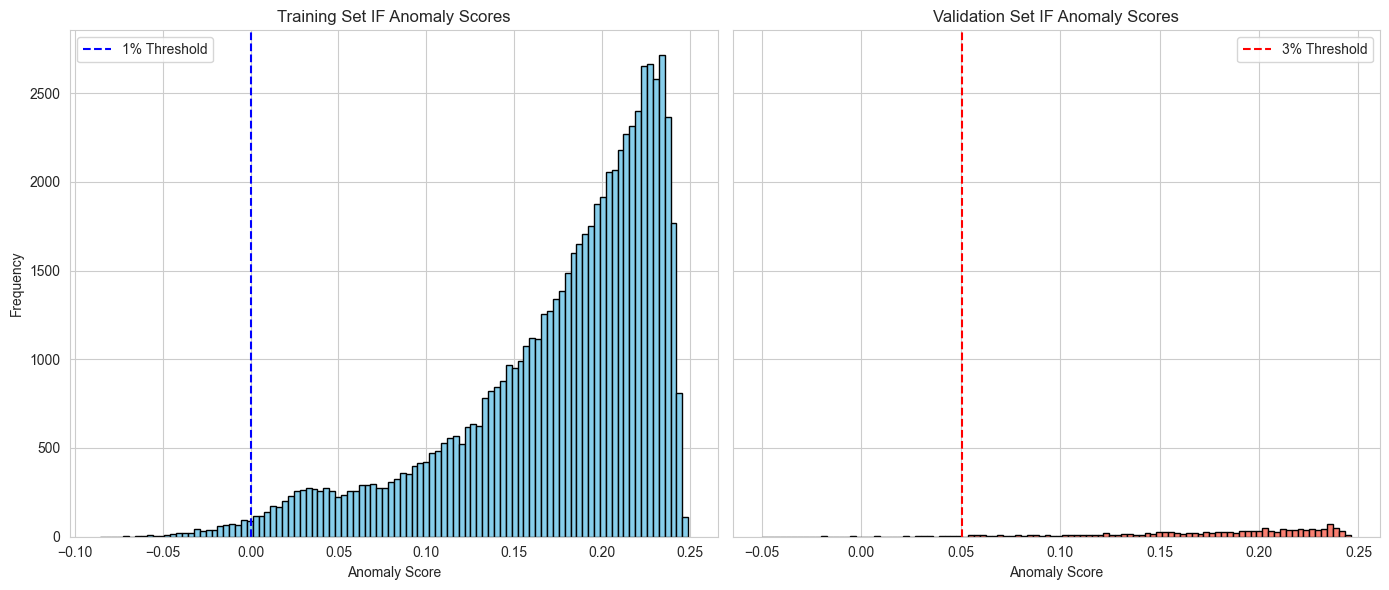

In [24]:
# Step 4.4: Plot anomaly scores for training and validation sets and their corresponding anomaly thresholds

# Extract existing scores and thresholds (already defined earlier)
train_scores = df_train['if_score'].dropna().values
val_scores = df_val['if_score'].dropna().values

# threshold_train and threshold_val are already defined using 1st and 3rd percentiles

# Plot
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axs[0].hist(train_scores, bins=100, color='skyblue', edgecolor='black')
axs[0].axvline(threshold_train, color='blue', linestyle='--', label='1% Threshold')
axs[0].set_title("Training Set IF Anomaly Scores")
axs[0].set_xlabel("Anomaly Score")
axs[0].set_ylabel("Frequency")
axs[0].legend()
axs[0].grid(True)

axs[1].hist(val_scores, bins=100, color='salmon', edgecolor='black')
axs[1].axvline(threshold_val, color='red', linestyle='--', label='3% Threshold')
axs[1].set_title("Validation Set IF Anomaly Scores")
axs[1].set_xlabel("Anomaly Score")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

***Interpreting Historgrams for Isolation Forest Score Thresholds***

These plots help explain how the 1% and 3% anomaly thresholds were applied to the training and validation sets.

- In the **training set**, the blue dashed line shows the **1% cut-off** (resting around 0.00), where only the most extreme points (far left tail) were flagged as anomalies.
- In the **validation set**, the red dashed line marks the **3% threshold** (around the 0.05 mark), allowing a slightly broader range of less typical values to pass through.

This approach supports our filtering logic — keeping LSTM-AE training focused on clean sequences while still testing it on more varied patterns. The different shapes of the two distributions are due to the difference in dataset sizes and thresholds, which is expected.

#### Step 5 – LSTM-AE Sequence Construction (Training)
**Goal**: Extract 30-day (720-hour) sequences from the training set for the LSTM Autoencoder.
Sequences must contain no NaNs and no more than 14 anomalous points (~2% of the sequence) to preserve training stability while retaining data coverage.

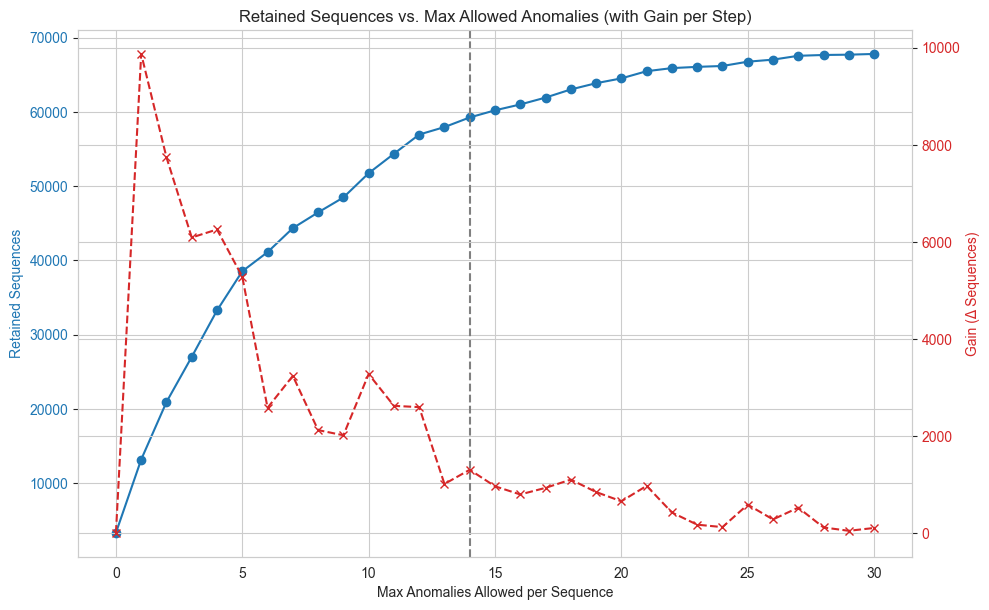

In [25]:
# Step 5.1: Determine the optimal number of allowed anomalies per sequence


# Run once compute the number of retained sequences for each threshold, then comment out (the code runs >25 mins!)
#==============================
# sequence_length = 720
# stride = 1
# thresholds = list(range(0, 31))  # 0 to 30 anomalies allowed
# retention_counts = []
#
# for max_anomalies in thresholds:
#     count_retained = 0
#
#     for start in range(0, len(df_train) - sequence_length + 1, stride):
#         window = df_train.iloc[start:start + sequence_length]
#
#         if window.isna().any().any():
#             continue
#
#         anomaly_count = window['is_if_anomaly'].sum()
#         if anomaly_count <= max_anomalies:
#             count_retained += 1
#
#     retention_counts.append(count_retained)
# =============================

# Reconstruct data due to kernel reset - comment out if running above
# =============================
thresholds = list(range(0, 31))
retention_counts = [
    3299, 13168, 20906, 26992, 33243, 38519, 41095, 44329, 46445, 48455,
    51726, 54342, 56932, 57938, 59237, 60195, 60985, 61911, 63007, 63847,
    64496, 65463, 65881, 66048, 66165, 66745, 67020, 67538, 67648, 67689, 67788
]
# =============================
# Convert to DataFrame
df = pd.DataFrame({'Max Anomalies': thresholds, 'Retained': retention_counts})

# First derivative: gain per additional anomaly
df['Gain'] = df['Retained'].diff().fillna(0)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Max Anomalies Allowed per Sequence')
ax1.set_ylabel('Retained Sequences', color=color)
ax1.plot(df['Max Anomalies'], df['Retained'], marker='o', color=color, label='Retained Sequences')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True)

# Plot gain on secondary axis
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Gain (Δ Sequences)', color=color)
ax2.plot(df['Max Anomalies'], df['Gain'], marker='x', color=color, linestyle='--', label='Gain per Step')
ax2.tick_params(axis='y', labelcolor=color)

# Add vertical line at likely sweet spot (e.g. 14)
ax1.axvline(x=14, linestyle='--', color='grey', label='Chosen Threshold (14)')

fig.tight_layout()
plt.title("Retained Sequences vs. Max Allowed Anomalies (with Gain per Step)")
plt.show()

**Choosing the Maximum Number of Anomalies per Sequence - Understanding the Plot**

This plot shows how the number of retained training sequences increases as we allow more anomalies per sequence.

- Allowing up to **14 anomalies** retains around **59,000 sequences**.
- This gives us a large, useful training set while still filtering out sequences with too many anomalies.
- After 14, the number of extra sequences gained slows down, meaning we get less benefit from relaxing the filter further.
- Choosing 14 as the cut-off gives us a good balance between **clean data** and **enough volume for training**.

This follows advice from Trinh (2022) and Darban (2024), who suggest allowing around 2% noise to avoid underfitting while still keeping the training set reliable.


In [26]:
# Step 5.2: Define Parameters and Initialise

# Sequence parameters
sequence_length = 720        # 30 days of hourly data
sequence_stride = 1          # Slide 1 hour at a time
max_allowed_anomalies = 14   # ~2% tolerance per sequence

# Features for LSTM-AE
lstm_input_cols_all = lstm_features + lstm_time_features

# Initialise counters and sequence store
debug_counts = {
    'total': 0,
    'has_nans': 0,
    'has_anomalies': 0,
    'added': 0
}
train_sequences = []

In [27]:
# Step 5.3: Construct Sequences from df_train

# Slide window across full training set
for start in range(0, len(df_train) - sequence_length + 1, sequence_stride):
    window = df_train.iloc[start:start + sequence_length]
    debug_counts['total'] += 1

    # Skip if any NaNs (e.g. due to rolling stats)
    if window.isna().any().any():
        debug_counts['has_nans'] += 1
        continue

    # Skip if anomaly count exceeds threshold
    if window['is_if_anomaly'].sum() > max_allowed_anomalies:
        debug_counts['has_anomalies'] += 1
        continue

    # If passed all checks, keep sequence
    train_sequences.append(window[lstm_input_cols_all].values)
    debug_counts['added'] += 1

# Report stats
print("Training sequence construction complete.")
print(f"Window stats: {debug_counts}")

Training sequence construction complete.
Window stats: {'total': 69409, 'has_nans': 719, 'has_anomalies': 9453, 'added': 59237}


**Anomaly Threshold Experiment Summary (Training Set)**

We tested how many training sequences could be created with different limits on how many anomalies are allowed per 720-hour (30-day) window.

The number of sequences with NaNs at 719 is fully justified by the 720-hour minimum window affecting the first 719 hours due to rolling stats.

With a maximum of 14 anomalies per sequence (around 2%), we kept over 59,000 training windows — about 87% of all usable sequences.

Reducing the limit to 7 anomalies (around 1%) led to 44,000 valid sequences — a 25% drop. This shows how stricter filtering reduces training data volume.

Studies by Darban (2024), Kulkarni et al. (2024), and Trinh (2022) support allowing 1–3% anomaly presence in training. It improves generalisation and avoids underfitting by keeping slight noise and variation. Based on this, we chose 14 anomalies as a balanced threshold for robust LSTM-AE training.

In [28]:
# Step 4.5: Stack into model-ready tensor
# Format: (n_sequences, 720, n_features)

X_train_lstm = np.stack(train_sequences)
print(f"LSTM training sequences: {X_train_lstm.shape}")

LSTM training sequences: (59237, 720, 8)


#### Step 6 – LSTM-AE Sequence Construction (Validation)
**Goal**: Extract 720-hour sequences from the validation set using the same feature columns, stride, and relaxed masking as in training.
This set is used for threshold tuning, early stopping, and SHAP analysis.

In [29]:
# Step 6.1: Define Parameters and Initialise

val_sequences = []
val_debug = {
    'total': 0,
    'has_nans': 0,
    'has_anomalies': 0,
    'added': 0
}

In [30]:
# Step 6.2: Slide window across validation set

for start in range(0, len(df_val) - sequence_length + 1, sequence_stride):
    window = df_val.iloc[start:start + sequence_length]
    val_debug['total'] += 1

    if window.isna().any().any():
        val_debug['has_nans'] += 1
        continue

    if window['is_if_anomaly'].sum() > max_allowed_anomalies:
        val_debug['has_anomalies'] += 1
        continue

    val_sequences.append(window[lstm_input_cols_all].values)
    val_debug['added'] += 1

print("Validation sequence construction complete.")
print(f"Validation window stats: {val_debug}")

Validation sequence construction complete.
Validation window stats: {'total': 1417, 'has_nans': 719, 'has_anomalies': 636, 'added': 62}


In [61]:
# Step 6.4: Audit of the timestamps in the accepted sequences

accepted_timestamps = set()

for i in range(0, len(df_val) - 720 + 1, sequence_stride):
    window = df_val.iloc[i:i+720]
    if window.isna().any().any(): continue
    if window['is_if_anomaly'].sum() > max_allowed_anomalies: continue
    accepted_timestamps.update(window.index)

accepted_timestamps = sorted(accepted_timestamps)
print(f"The {val_debug['added']} accepted sequences span {len(accepted_timestamps)} timestamps.\n"
      f"Sequence length: {sequence_length} \n"
      f"Stride: {sequence_stride} \n"
      f"{val_debug['added']} * {sequence_stride} + {sequence_length} - 1 = {val_debug['added'] * sequence_stride + sequence_length - 1}"
      )

The 62 accepted sequences span 781 timestamps.
Sequence length: 720 
Stride: 1 
62 * 1 + 720 - 1 = 781


In [62]:
print(f"Sequences span from {min(accepted_timestamps)} to {max(accepted_timestamps)}")

Sequences span from 2025-03-11 03:00:00 to 2025-04-12 15:00:00


**Validation Sequence Coverage Summary**

After filtering for NaNs and excessive anomalies, **62 validation sequences** were accepted for LSTM-AE evaluation. These sequences:

- Span from **11 March to 12 April 2025**,
- Each cover **720 hours (30 days)** with stride 1,
- Follow the rule of allowing **no missing values** and **no more than 14 anomalies** per window.

This filtering ensures that the model is tested on **clean and reliable data**, in line with guidance from Trinh (2022) and Darban (2024), who recommend allowing up to 2% anomaly tolerance.

If wider coverage is needed, the anomaly threshold can be raised slightly.


In [31]:
# Step 6.3: Final shape: (n_val_sequences, 720, n_features)

X_val_lstm = np.stack(val_sequences)
print(f"LSTM validation sequences: {X_val_lstm.shape}")

LSTM validation sequences: (62, 720, 8)


#### Step 7 – Save Processed Sequences and Transformed Data
**Goal**: Persist key outputs including preprocessed training and validation dataframes, and their corresponding LSTM-AE tensors.
This allows reuse for model training, threshold tuning, and interpretability tasks without re-running all preprocessing steps.

In [32]:
# Save transformed DataFrames (optional but useful for SHAP/debugging)
df_train.to_csv(os.path.join(MODEL_INPIT_OUTPUT_DIR, 'df_train_preprocessed.csv'))
df_val.to_csv(os.path.join(MODEL_INPIT_OUTPUT_DIR, 'df_val_preprocessed.csv'))

# Save LSTM-AE ready sequences
np.save(os.path.join(MODEL_INPIT_OUTPUT_DIR, 'X_train_lstm.npy'), X_train_lstm)
np.save(os.path.join(MODEL_INPIT_OUTPUT_DIR, 'X_val_lstm.npy'), X_val_lstm)

#### Step 8 – Train the LSTM Autoencoder
**Goal**: Train an LSTM-based autoencoder on the 720-hour sequences (X_train_lstm) to learn normal weather patterns.
During evaluation, sequences that produce high reconstruction error will be considered anomalous.

In [33]:
# Step 8.1: Define the LSTM-AE Architecture

# Get sequence and feature dimensions
timesteps = X_train_lstm.shape[1]  # e.g. 720
n_features = X_train_lstm.shape[2] # e.g. 8

# Define model
input_layer = Input(shape=(timesteps, n_features))

# Encoder
encoded = LSTM(64, activation='tanh', return_sequences=True)(input_layer)
encoded = LSTM(32, activation='tanh', return_sequences=False)(encoded)

# Bottleneck
bottleneck = RepeatVector(timesteps)(encoded)

# Decoder
decoded = LSTM(32, activation='tanh', return_sequences=True)(bottleneck)
decoded = LSTM(64, activation='tanh', return_sequences=True)(decoded)
decoded = TimeDistributed(Dense(n_features))(decoded)

# Assemble
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mae')

# Print summary
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 720, 8)]          0         
                                                                 
 lstm (LSTM)                 (None, 720, 64)           18688     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 repeat_vector (RepeatVector  (None, 720, 32)          0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 720, 32)           8320      
                                                                 
 lstm_3 (LSTM)               (None, 720, 64)           24832     
                                                             

#### Step 9 – Train the LSTM Autoencoder with Early Stopping <br>
**Goal**: Train the LSTM-AE to reconstruct normal sequences using MAE loss.
Early stopping prevents overfitting by halting training when validation loss no longer improves.

**Training Configuration Summary**

We trained the LSTM Autoencoder using the following settings:

Loss = 'mae' (Mean Absolute Error):
MAE is used to measure how closely the model can reconstruct each value in a sequence. It is more robust to outliers than MSE and works well for threshold-based anomaly detection (Trinh, 2022; Darban, 2024).

Batch size = 32:
This is a typical batch size for time-series data. It allows the model to learn temporal dependencies while maintaining training efficiency (Kulkarni et al., 2024).

Epochs = 100 with early stopping (patience = 5):
Early stopping halts training when the validation loss stops improving. This prevents overfitting and saves resources (Bâra et al., 2024).

ModelCheckpoint:
We saved the best-performing model (based on validation loss) to a .h5 file for reuse. This avoids retraining and supports downstream analysis (Antwarg et al., 2021).

Shuffle = True:
Shuffling training sequences prevents the model from overfitting to local trends and improves generalisation (Darban, 2024).

*Note: Track GPU usage during training, enter `cmd` in Windows search and enter `nvidia-smi -l 5`

Epoch 1/100

Epoch 1: val_loss improved from inf to 113.68618, saving model to outputs/modelling/models\lstm_ae_best.h5
1852/1852 - 309s - loss: 120.5731 - val_loss: 113.6862 - 309s/epoch - 167ms/step
Epoch 2/100

Epoch 2: val_loss improved from 113.68618 to 99.42087, saving model to outputs/modelling/models\lstm_ae_best.h5
1852/1852 - 299s - loss: 106.3257 - val_loss: 99.4209 - 299s/epoch - 161ms/step
Epoch 3/100

Epoch 3: val_loss improved from 99.42087 to 85.29520, saving model to outputs/modelling/models\lstm_ae_best.h5
1852/1852 - 292s - loss: 92.1637 - val_loss: 85.2952 - 292s/epoch - 158ms/step
Epoch 4/100

Epoch 4: val_loss improved from 85.29520 to 70.67432, saving model to outputs/modelling/models\lstm_ae_best.h5
1852/1852 - 300s - loss: 77.8746 - val_loss: 70.6743 - 300s/epoch - 162ms/step
Epoch 5/100

Epoch 5: val_loss improved from 70.67432 to 55.77272, saving model to outputs/modelling/models\lstm_ae_best.h5
1852/1852 - 302s - loss: 63.0640 - val_loss: 55.7727 - 302s/epoc

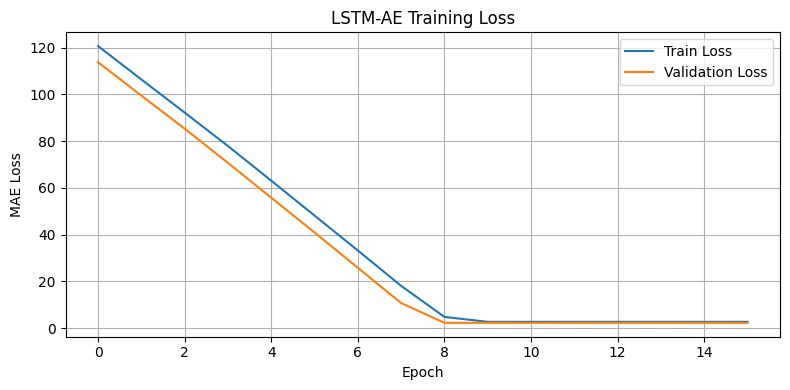

In [33]:
# Step 9.1: Train the LSTM Autoencoder model

# uncomment the code below for retraining

## Define callbacks
# early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
#
# model_checkpoint = ModelCheckpoint(
#     filepath='outputs/modelling/models/lstm_ae_best.h5',
#     monitor='val_loss',
#     save_best_only=True,
#     verbose=1
# )
#
# # Train the model
# history = autoencoder.fit(
#     X_train_lstm, X_train_lstm,
#     epochs=100,
#     batch_size=32,
#     validation_data=(X_val_lstm, X_val_lstm),
#     callbacks=[early_stopping, model_checkpoint],
#     shuffle=True,
#     verbose=2
# )

## Plot training history
# plt.figure(figsize=(8, 4))
# plt.plot(history.history['loss'], label='Train Loss')
# plt.plot(history.history['val_loss'], label='Validation Loss')
# plt.xlabel("Epoch")
# plt.ylabel("MAE Loss")
# plt.title("LSTM-AE Training Loss")
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

**LSTM-AE Training Summary**

The LSTM Autoencoder was trained for up to 100 epochs with early stopping (patience = 5) based on validation loss (MAE). The model achieved rapid and stable convergence:

- **Initial val_loss:** 113.69
- **Best val_loss:** 2.29 (Epoch 11)
- **Training loss plateaued** around 2.74 from Epoch 9 onward
- **No signs of overfitting** — val_loss continued improving until early stopping was triggered

This learning behaviour suggests the model has successfully learned to reconstruct "normal" sequences and is now well-suited to flag outliers during inference. The final model was saved at Epoch 11.

This performance is consistent with similar LSTM-AE implementations in time series anomaly detection literature (Trinh, 2022; Darban, 2024; Yang, 2023), where MAE values in the 2–5 range were typical after normalisation and robust sequence filtering.


#### Step 10: Evaluate the trained LSTM-AE model using the validation set
**Goal**: The aim of this step is to evaluate the trained LSTM Autoencoder on the validation set and assess how well it reconstructs the input weather sequences.

This is achieved by calculating the reconstruction error (mean absolute error, MAE) for each hour, then aggregating these errors by timestamp to identify potential anomalies. This timestamp-level scoring will later be merged into `df_val` to support downstream interpretability, dashboard display, and hybrid labelling.

This step ensures that we:
- Detect **pattern anomalies** missed by Isolation Forest (IF),
- Provide consistent scoring per hour for explainability,
- Flag timestamps with unexpectedly high reconstruction error.

This approach aligns with Trinh (2022), Kulkarni (2024), and Bâra (2024), who all use reconstruction error statistics and percentile-based thresholds to identify temporal outliers.

In [98]:
# Step 10.1: Compute mean reconstruction errors per timestamp

# Predict reconstruction from trained LSTM-AE
recon_val = autoencoder.predict(X_val_lstm, verbose=1)

# Compute per-timestep MAE (across features)
reconstruction_errors = np.mean(np.abs(X_val_lstm - recon_val), axis=2)  # shape: (n_sequences, 720)

# Rebuild true validation sequence timestamps from filtered logic (Step 6.2)
valid_sequence_starts = []  # only for accepted sequences

for i in range(0, len(df_val) - 720 + 1, sequence_stride):
    window = df_val.iloc[i:i+720]
    if window.isna().any().any(): continue
    if window['is_if_anomaly'].sum() > max_allowed_anomalies: continue
    valid_sequence_starts.append(window.index[0])

# Sanity check
assert len(valid_sequence_starts) == reconstruction_errors.shape[0], "Mismatch in accepted sequence count!"

# Flatten timestamps and errors
timestamps = []
errors = []

for i in range(len(valid_sequence_starts)):
    start_time = valid_sequence_starts[i]
    for j in range(720):
        timestamps.append(start_time + pd.Timedelta(hours=j))
        errors.append(reconstruction_errors[i, j])

# Create tidy DataFrame
df_lstm_recon_errors = pd.DataFrame({
    'timestamp': timestamps,
    'reconstruction_error': errors
})

# Sort and preview
df_lstm_recon_errors.sort_values('timestamp', inplace=True)
df_lstm_recon_errors.reset_index(drop=True, inplace=True)

2/2 [==============================] - 0s 184ms/step


**Why we need the mean MAE per timestamp**

Each hour in the validation set may appear in multiple sequences due to the sliding window.

To ensure each timestamp has one meaningful score, we compute the **mean reconstruction error (MAE) per timestamp**. This gives a fair, unbiased view of how well the model reconstructed that hour, in line with best practice for multistep time-series evaluation (Wenig, 2022; Darban, 2024).


In [99]:
# Step 10.1 continued: Compute mean LSTM-AE reconstruction error (MAE) per timestamp

df_lstm_recon_errors_agg = (
    df_lstm_recon_errors
    .groupby('timestamp')['reconstruction_error']
    .mean()
    .reset_index()
    .rename(columns={'reconstruction_error': 'lstm_score'})
)

df_lstm_recon_errors_agg["lstm_score"].describe()

count    781.000000
mean     129.772280
std        1.371748
min      126.213227
25%      129.041052
50%      129.978258
75%      130.747235
max      132.554840
Name: lstm_score, dtype: float64

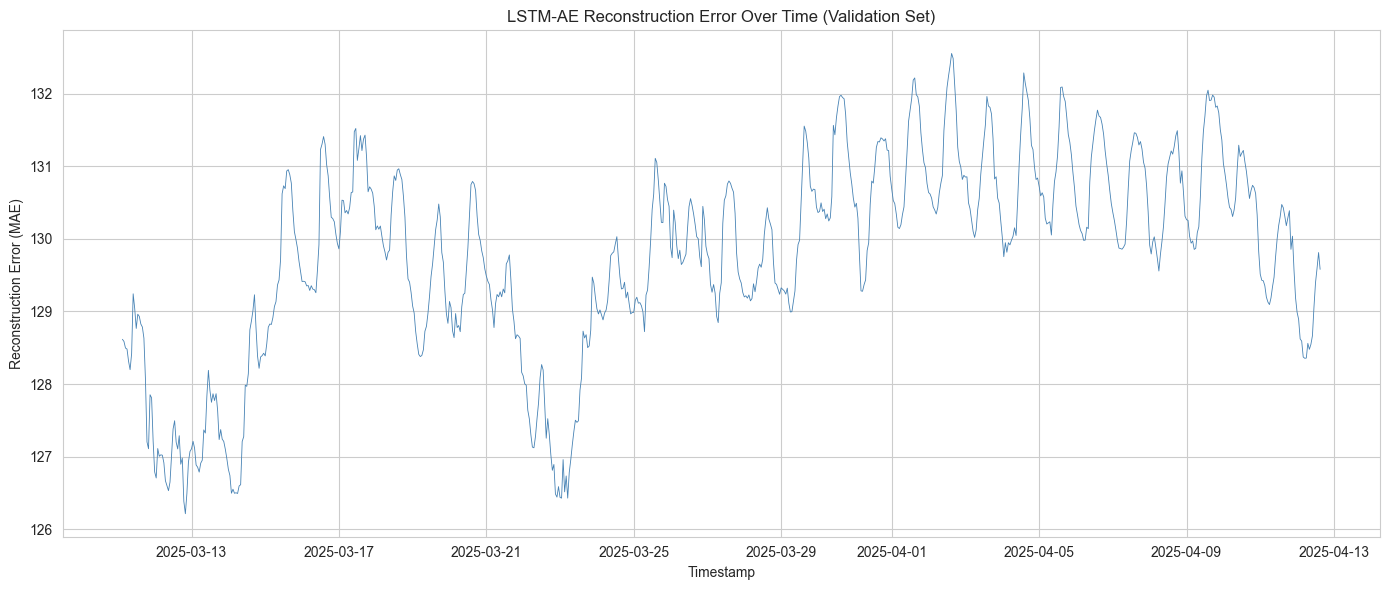

In [100]:
# Step 10.2: Plotting mean reconstruction errors per timestamp over time

plt.figure(figsize=(14, 6))
plt.plot(df_lstm_recon_errors_agg['timestamp'], df_lstm_recon_errors_agg['lstm_score'], color='steelblue', linewidth=0.6)
plt.title("LSTM-AE Reconstruction Error Over Time (Validation Set)")
plt.xlabel("Timestamp")
plt.ylabel("Reconstruction Error (MAE)")
plt.grid(True)
plt.tight_layout()
plt.show()

Next, we merge the per-timestamp LSTM-AE reconstruction error (`lstm_score`) into `df_val` to provide a unified DataFrame for anomaly scoring and downstream explainability.

This ensures each row now contains:
- Input weather features,
- `if_score` and `is_if_anomaly` from Isolation Forest,
- `lstm_score` from the Autoencoder.

This merged structure supports hybrid labelling (e.g. compound anomaly detection), explainable AI attribution (e.g. TreeSHAP, IG), and dashboard reporting.

In [103]:
# Step 10.3 Merge the LSTM-AE score (mean MAE per timestamp) into df_val

# Join using timestamp alignment (df_val index is datetime-based)

if 'lstm_score' in df_val.columns:
    df_val.drop(columns='lstm_score', inplace=True)

df_val = df_val.merge(
    df_lstm_recon_errors_agg,
    how='left',
    left_index=True,
    right_on='timestamp'
).set_index('timestamp')


df_val.head()

,temperature_2m,surface_pressure,wind_speed_10m,precipitation,temperature_2m_z,surface_pressure_z,wind_r,precip_log,precip_z_12h,hour,hour_sin,hour_cos,month,month_sin,month_cos,if_score,is_anomaly,lstm_score_x,lstm_score_y,lstm_score
timestamp,,,,,,,,,,,,,,,,,,,,
2025-02-01 00:00:00,3.8,1025.9,2.9,0.0,NaN,NaN,NaN,0.0,NaN,0,0.000000,1.000000,2,0.866025,0.5,NaN,False,NaN,NaN,NaN
2025-02-01 01:00:00,3.6,1026.1,3.4,0.0,NaN,NaN,NaN,0.0,NaN,1,0.258819,0.965926,2,0.866025,0.5,NaN,False,NaN,NaN,NaN
2025-02-01 02:00:00,5.4,1026.3,4.4,0.0,NaN,NaN,NaN,0.0,NaN,2,0.500000,0.866025,2,0.866025,0.5,NaN,False,NaN,NaN,NaN
2025-02-01 03:00:00,5.6,1026.5,6.9,0.0,NaN,NaN,NaN,0.0,NaN,3,0.707107,0.707107,2,0.866025,0.5,NaN,False,NaN,NaN,NaN
2025-02-01 04:00:00,5.2,1026.6,6.6,0.0,NaN,NaN,NaN,0.0,NaN,4,0.866025,0.500000,2,0.866025,0.5,NaN,False,NaN,NaN,NaN


Below we compared three common thresholding methods to flag potential anomalies in LSTM-AE reconstruction scores:

- **Mean + 2×Standard Deviation** (a classic statistical cut-off),
- **95th percentile** (top 5% of scores),
- **99th percentile** (very strict, top 1%).

These methods are widely used in unsupervised time-series anomaly detection. Trinh (2022) and Kulkarni (2024) recommend percentile-based thresholds for their adaptability, while Bâra (2024) applies similar thresholds in hybrid weather anomaly pipelines. Wenig (2022) further supports this in a review of modern multivariate anomaly detection techniques.

In [113]:
# Step 10.4: Compute anomaly thresholds using three methods for lstm_score

# Drop NA values in case some timestamps were unmatched during merge
valid_lstm_scores = df_val['lstm_score'].dropna()

# A. Mean + 2×Standard Deviation
mean_lstm = valid_lstm_scores.mean()
std_lstm = valid_lstm_scores.std()
threshold_mean_2std = mean_lstm + 2 * std_lstm

# B. 95th Percentile
threshold_95 = valid_lstm_scores.quantile(0.95)

# C. 99th Percentile
threshold_99 = valid_lstm_scores.quantile(0.99)

# Show thresholds
print("Thresholds for LSTM-AE reconstruction error:")
print(f"Mean + 2×Std: {threshold_mean_2std:.4f}")
print(f"95th Percentile: {threshold_95:.4f}")
print(f"99th Percentile: {threshold_99:.4f}")


Thresholds for LSTM-AE reconstruction error:
Mean + 2×Std: 132.5158
95th Percentile: 131.7738
99th Percentile: 132.1334


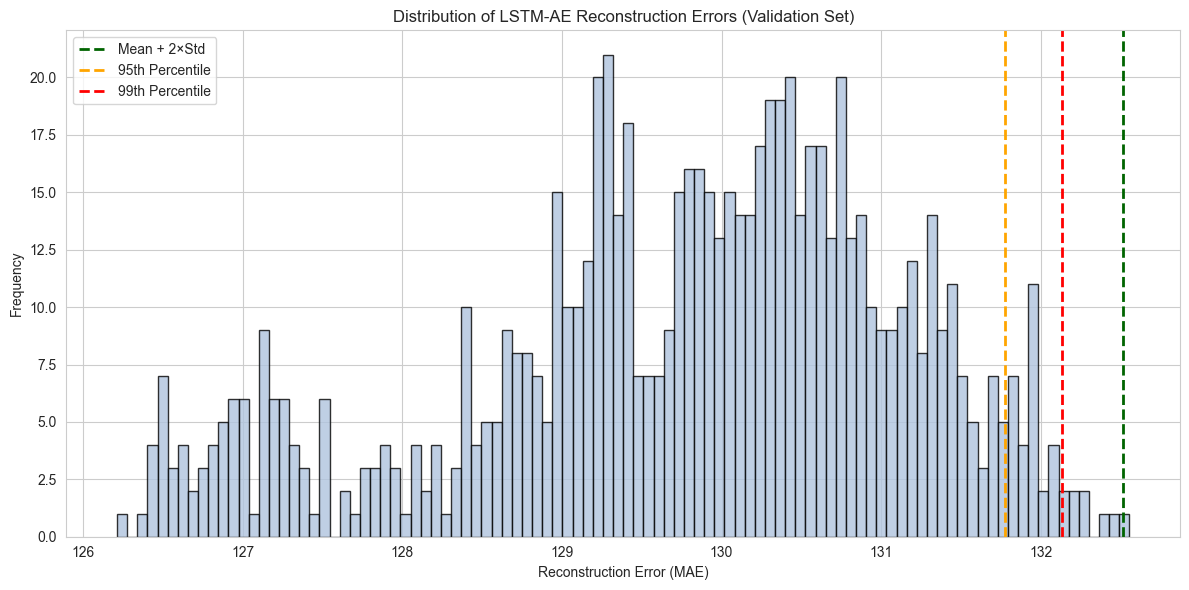

In [114]:
# Step 10.5: Visualise reconstruction errors with thresholds

# Plot histogram of reconstruction errors with thresholds
plt.figure(figsize=(12, 6))
plt.hist(valid_lstm_scores, bins=100, color='lightsteelblue', edgecolor='black', alpha=0.8)

# Add threshold lines
plt.axvline(threshold_mean_2std, color='darkgreen', linestyle='--', linewidth=2, label='Mean + 2×Std')
plt.axvline(threshold_95, color='orange', linestyle='--', linewidth=2, label='95th Percentile')
plt.axvline(threshold_99, color='red', linestyle='--', linewidth=2, label='99th Percentile')

# Labels and formatting
plt.title("Distribution of LSTM-AE Reconstruction Errors (Validation Set)")
plt.xlabel("Reconstruction Error (MAE)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation of the Histogram**

The histogram shows a **left-skewed** distribution, where most timestamps have similar reconstruction scores and a few are reconstructed extremely well.

This makes sense: we only used **1 month of clean, accepted sequences** (from March to early April). These were selected to be stable and reliable — so it's normal that the LSTM-AE reconstructed them well.

After reviewing the distribution, we selected the **95th percentile** as our final threshold. This method is widely used in unsupervised time-series anomaly detection because it adapts well to real-world score distributions and avoids relying on normality assumptions (Trinh, 2022; Kulkarni, 2024; Bara, 2024). It also offers a balance between sensitivity and precision, unlike stricter thresholds that risk missing useful signals.


In [115]:
# Step 10.6: Flag anomalies using the 95th percentile

# Reuse or recompute the threshold
threshold_95 = df_val['lstm_score'].dropna().quantile(0.95)

# Create a new boolean flag
df_val['is_lstm_anomaly'] = df_val['lstm_score'] > threshold_95

# Optional: check how many were flagged
n_anomalies = df_val['is_lstm_anomaly'].sum()
print(f"Timestamps flagged as LSTM anomalies: {n_anomalies}")

Timestamps flagged as LSTM anomalies: 39
